# Coursework 2 - Question 3

#### Import all dependencies

In [237]:
from random import choice
import random as rd
from agents import *
#from notebook import psource
import time #for debugging purposes

#for search
from search import *
from notebook import psource, heatmap, gaussian_kernel, show_map, final_path_colors, display_visual, plot_NQueens

#needed to hide warnings in the matplotlib sections
import warnings
warnings.filterwarnings("ignore")

#use for boundary checking. is_inbound doesn't work properly for whatever reason
global w, h, person_location, things_loc  #personal location to make it available to the method that returns the agent
#things_loc is for the search

# Question 3.1

#### a) Create all things possible in environment (3 things and 1 agent)

In [238]:
class SprayedObject(Thing): #class for sprayed objects. is invisible to agent (cannot sense it)
    pass
        
class Chair(Thing):
#     def spray(): #internal attribute will tell us whether object has been sprayed
#         self.sprayed=True
    pass
        
class Trolley(Thing):
    pass

class Person(Thing):
    pass

In [239]:
class CovidRobot(Agent):
    location = [0, 0] #robot starts at starting point
    
    def __init__(self, program, limit,  counter=0,):
        Agent.__init__(self, program)
        self.program = program
        self.limit = limit
        self.counter = counter
    def move_up(self):
        self.location[1] -= 1
    def move_down(self):
        self.location[1] += 1 
    def move_left(self):
        self.location[0] -= 1
    def move_right(self):
        self.location[0] += 1
    def spray(self):
        self.counter += 1 #will be used to check if there are any items left in the environement
        
    def return_back(self):
        pass
            

### b) Specify agent program 

In [240]:
'''
Returns an action based on it's percepts
The action will be fulfilled by execute_action() of the environment
Program simply maps a percept to an action
'''
def covid_program(percepts):
    things, up, down, left, right = percepts #percept returns all these values. store them into variables for ease
    choice_map = { #if we see say a Person to the right, we store 'r' and extract 1 from the dict. 1 will be removed from the places we can go randomly
        'u':1, 
        'd':2, 
        'l':3, 
        'r':4 }
    people = [] #if the thing we feel is a person around us, keep track of locations they're at if we want to move randomly
    bumps = []
    choice = [1, 2, 3, 4] #initially we can move anywhere randomly

      #for cell we're on
    for t in things:
        if isinstance(t, Chair) or isinstance(t, Trolley):
            return 'spray'

        if isinstance(t[0], Bump): #if t is not a chair, trolley, it's likely a bump object. we only needed it so we can avoid the border for random moves
            #by now there's nothing to spray around us as we wouldve sensed it, so move randomly
            bumps.append(choice_map[str(t[1])[0:1]]) #gives the first letter of move that take us to boundary(e.g 'r' for right). putting it into the choice dictionary gives us the numbers we want to avoid for our random choice
      
    #for cells around us
    for u in up: #we use a for loop just in case there's nothing inside
        if isinstance(u, Chair) or isinstance(u, Trolley):
                return 'move_up'
        elif isinstance(u, Person):
            people.append(choice_map['u'])
    for d in down:
        if isinstance(d, Chair) or isinstance(d, Trolley):
                return 'move_down'
        elif isinstance(d, Person):
            people.append(choice_map['d'])
    for l in left:
        if isinstance(l, Chair) or isinstance(l, Trolley):
                return 'move_left'
        elif isinstance(l, Person):
            people.append(choice_map['l'])
    for r in right:
        if isinstance(r, Chair) or isinstance(r, Trolley):
                return 'move_right'
        elif isinstance(r, Person):
            people.append(choice_map['r'])

    #now there isn't any food, lets check if there's any boundaries around us
    if bumps: #if there are any bumps
        choice = tuple(set(choice) - set(bumps))  #remove the places we cannot go  
    if people: #if there are any people around us
        choice = tuple(set(choice) - set(people))
        
    #print(choice) #debugging purposes - we see the list of possible actions for random moves
    choice = random.choice(choice) #returns 1 of the possible choices. should always be atleast 1 executable action for any dimension nxn where n>1 as there can only be 1 person in environment at any given time
    
    #now we have an executable choice, lets take it and map a percept 
    if choice == 1:
        return 'move_up'
    elif choice == 2:
        return 'move_down'
    elif choice == 3:
        return 'move_left'
    elif choice == 4:
        return 'move_right'
    

### c) Specify agent environment 

In [241]:
class World(GraphicEnvironment):
    '''
    This method defines all the things our agent can sense
    return: a list of things that are in our agent's location
    return: whether we're at an edge
    return: things up, down, left and right
    '''
    def percept(self, agent): 
        global w, h  #use if is_inbound stops working
        # initiate lists since we may not enter if block- can reset at every method call
        things_up, things_down, things_left, things_right = [], [], [], []
        
        #1. First thing he can feel is what the stuff in the block he's standing on to make sure what he sensed is correct
        things = self.list_things_at(agent.location)
        things = [thing for thing in things if not isinstance(thing, CovidRobot)]
        
        #2. Agent can also feel what's up, down, left, right.
        up = [agent.location[0], agent.location[1] - 1]
        down = [agent.location[0], agent.location[1] + 1]
        left = [agent.location[0] - 1, agent.location[1]]
        right = [agent.location[0] + 1, agent.location[1]]
        
        #3. Before returning what's in neighbouring cell, check if it is in the environment. If it isn't, add a bump object to current position
        if up[0] > h or up[1] > w or up[0] < 0 or up[1] < 0:
            things.append((Bump(), 'up')) #we don't have a direction so we'll store where the bump is in a tuple
        else:
            things_up = self.list_things_at(up)
            
        if down[0] > h or down[1] > w or down[0] < 0 or down[1] < 0:
            things.append((Bump(), 'down'))
        else:
            things_down = self.list_things_at(down)
            
        if left[0] > h or left[1] > w or left[0] < 0 or left[1] < 0:
            things.append((Bump(), 'left'))
        else:
            things_left = self.list_things_at(left)              
            
        if right[0] > h or right[1] > w or right[0] < 0 or right[1] < 0:
            things.append((Bump(), 'right'))
        else:
            things_right = self.list_things_at(right)
            
        return things, things_up, things_down, things_left, things_right
    
    '''
    Execute an action either in the method or by calling another
    Program either stops or returns to listening for percepts
    '''                      
    def execute_action(self, agent, action):
        #synchronous with a step
        if action == 'move_up':
            print("Searching...")
            agent.move_up()
        elif action == 'move_down':
            print("Searching...")
            agent.move_down()
        elif action == 'move_left':
            print("Searching...")
            agent.move_left()  
        elif action == 'move_right': 
            print("Searching...")
            agent.move_right()
        elif action == 'spray':
            print("Spraying")
            thing = self.list_things_at(agent.location)
            thing = [thing for thing in thing if not isinstance(thing, CovidRobot)]
            world.delete_thing(thing[0])
            #world.add_thing(SprayedObject(), agent.location)
            agent.spray() #increases an internal counter
            self.update() #manually update gui to give time for spray
            
            '''
            return back to [0, 0] and navigate around person and border
            '''
            avoid = person_location
            loc = agent.location
            print("Returning home")
            while loc[0] > 0: #move to the far left
                left_x = loc[0] - 1 #our x coordinate to left
                if [x, loc[1]] == avoid and loc[1] != 0: #if person to left and we can move up
                    agent.move_up()
                    self.update()
                elif [x, loc[1]] == avoid: #if we cannot move up, go down and carry on going left
                    agent.move_down()
                    self.update()
                    
                agent.move_left() #carry on moving left
                self.update() #for visualisation. updates gui to show travel back to start after spraying

            while loc[1] > 0: #go up to [0, 0]
                up_y = loc[1] - 1
                if [loc[0], up_y] == avoid[0]: #if a person above, go around them
                    agent.move_right()
                    self.update()
                    agent.move_up() #move up 2 times to go past person
                    self.update()
                    agent.move_up()
                    self.update()
                    agent.move_left() #go back to the zero coordinate for the x-axis
                    self.update()
  
                agent.move_up()
                self.update()
                
                
                
            if agent.counter == agent.limit: #check if we're finished spraying
                print("Finished spraying")
                agent.alive = False #turn robot off after finishing all the spraying in environment

                    
    def is_done(self):
        pass


### d) Run environment

In [245]:
world = World(4,4, color={'CovidRobot': (255,0,0), 'Chair': (255, 199, 67), 'Trolley': (255, 199, 67), 'SprayedObject': (0, 255, 0), 'Person': (165, 165, 165)})
w = world.width - 1 #will be global
h = world.height - 1 #will be global. also used for boundary check as is_inbound() doesn't work for whatever reason
n = rd.randint(1, w + 1) # number of objects in environment (less than width (or height)). remember n for later seeing if we've removed all the items. add atleast 1 thing and up to 4
covid_robot = CovidRobot(covid_program, n) #we take n as an argument to know when we have sprayed all the objects and terminate
items = [[0, 0]]
things_loc = [] #useful for search later
world.add_thing(covid_robot, [0,0])
person_location = []
x, y = 0, 0
while(x == 0 and y == 0):
    x = rd.randint(0, w) #w == h so can use interchangeably
    y = rd.randint(0, h)
    person_location = [x, y]
world.add_thing(Person(), person_location) #add a person to a random location
items.append(person_location)

while len(items) < n + 2: #we pick a random number of items and persist this number for the start of the run. the +2 includes the 1 person in the list and the initial state. (n items location + agent loc + person loc )
    x = random.randint(0, w)
    y = random.randint(0, h)
    thing = [Chair(), Trolley()][random.randint(0, 1)] #pick 1 out of the 2 items to place everytime
    if [x, y] not in items: #make sure we dont place 2 things at the same place
        items.append([x, y])
        things_loc.append([x, y])
        world.add_thing(thing, [x, y])
        
        
world.run(100)

,,,
,,,
,,,
,,,


Searching...


KeyboardInterrupt: 

### Question 3.1 Summary
| Objective | Position in Code |
| :--- | :--- |
| Making an environment that adds objects and a person | d) |
| Making the agent that can receive precepts and can move and spray | b) and c) |
| Making the agent that can return to the start points after each spraying | c) |


---------------------------------------------------------------------------------------------------------------------


# Question 3.2 - The implementation of the program is imbedded into all the sections above. Run all cells up to (d) to see to visualise the implementation

#### Explanation of algorithm

1. The algorithm (as defined in the program) has a list of percepts specifying what is in every cell to the top, bottom, left and right of the agent, assuming 'neighbouring cells' means directly connected cells.
2. Our first priority is items. If we see an item, we move towards that cell.
3. If that thing is a person, we make sure we avoid that cell
4. By doing this, we always move to the most optimal position in the environment
5. If we're on a cell where we can spray, we spray immediately.
6. We also avoid moving outside of the environmen
7. Else, we move to a random cell in an attempt to be near an item again
8. **In terms of minimum moves, I don't see how this is posible considering the question says an agent can only see the closest cell. A search algorithm would assume the robot knows where in the environment the items and person are, hence I've avoided this**
9. Moving randomly utilises probability and the chances of finally encountering a cell that has items around it, although for larger environments, it would be more reasonable to move systematically, from left to right, top to bottom as random movement may make the agent go to positions already visited, making the worst-case scenario very inefficient


---------------------------------------------------------------------------------------------------------------------


# Question 3.3 - The code above contains all the functionality, however we make a distinct change

### Explanation of change to algorithm

1. Instead of returning for every spray, we make note of how many items are still left in the environment. Here, I make a questionable assumption that the agent knows the number of items in the environment that need spraying
2. Again, when we finish spraying all items in the environment, we return and turn the machine off.

**Run the cell below and rerun section d) to see the difference**

In [243]:
class World(GraphicEnvironment):
    '''
    This method defines all the things our agent can sense
    return: a list of things that are in our agent's location
    return: whether we're at an edge
    return: things up, down, left and right
    '''
    def percept(self, agent): 
        global w, h  #use if is_inbound stops working
        # initiate lists since we may not enter if block- can reset at every method call
        things_up, things_down, things_left, things_right = [], [], [], []
        
        #1. First thing he can feel is what the stuff in the block he's standing on to make sure what he sensed is correct
        things = self.list_things_at(agent.location)
        things = [thing for thing in things if not isinstance(thing, CovidRobot)]
        
        #2. Agent can also feel what's up, down, left, right.
        up = [agent.location[0], agent.location[1] - 1]
        down = [agent.location[0], agent.location[1] + 1]
        left = [agent.location[0] - 1, agent.location[1]]
        right = [agent.location[0] + 1, agent.location[1]]
        
        #3. Before returning what's in neighbouring cell, check if it is in the environment. If it isn't, add a bump object to current position
        if up[0] > h or up[1] > w or up[0] < 0 or up[1] < 0:
            things.append((Bump(), 'up')) #we don't have a direction so we'll store where the bump is in a tuple
        else:
            things_up = self.list_things_at(up)
            
        if down[0] > h or down[1] > w or down[0] < 0 or down[1] < 0:
            things.append((Bump(), 'down'))
        else:
            things_down = self.list_things_at(down)
            
        if left[0] > h or left[1] > w or left[0] < 0 or left[1] < 0:
            things.append((Bump(), 'left'))
        else:
            things_left = self.list_things_at(left)              
            
        if right[0] > h or right[1] > w or right[0] < 0 or right[1] < 0:
            things.append((Bump(), 'right'))
        else:
            things_right = self.list_things_at(right)
            
        return things, things_up, things_down, things_left, things_right
    
    '''
    Execute an action either in the method or by calling another
    Program either stops or returns to listening for percepts
    '''                      
    def execute_action(self, agent, action):
        #synchronous with a step
        if action == 'move_up':
            agent.move_up()
            print("Searching...")
        elif action == 'move_down':
            print("Searching...")
            agent.move_down()
        elif action == 'move_left':
            agent.move_left()  
            print("Searching...")
        elif action == 'move_right':              
            agent.move_right()
            print("Searching...")
            
        elif action == 'spray':
            print("Spraying")
            thing = self.list_things_at(agent.location)
            thing = [thing for thing in thing if not isinstance(thing, CovidRobot)]
            world.delete_thing(thing[0])
            #world.add_thing(SprayedObject(), agent.location)
            agent.spray() #increases an internal counter
            self.update() #manually update gui to give time for spray
            #print("{}-->{}".format(agent.counter, agent.limit)) - debugging 
            '''
            CHANGE: counter keeps track of how many items we've sprayed 
            while limit keeps track of the items in the environment.
            We only return back to start after these numbers are the same,
            hereby turning the machine off
            '''
            if agent.counter == agent.limit: #check if we're finished spraying
                '''
                return back to [0, 0] and navigate around person and border
                '''
                avoid = person_location
                loc = agent.location



                while loc[0] > 0: #move to the far left
                    left_x = loc[0] - 1 #our x coordinate to left
                    if [x, loc[1]] == avoid and loc[1] != 0: #if person to left and we can move up
                        agent.move_up()
                        self.update()
                    elif [x, loc[1]] == avoid: #we cannot move up
                        agent.move_down()
                        self.update()

                    agent.move_left() #carry on move left
                    self.update() #for visualisation. updates gui to show travel back to start after spraying

                while loc[1] > 0: #go up to [0, 0]
                    up_y = loc[1] - 1
                    if [loc[0], up_y] == avoid[0]: #if a person above, go around them
                        agent.move_right()
                        self.update()
                        agent.move_up() #move up 2 times to go past person
                        self.update()
                        agent.move_up()
                        self.update()
                        agent.move_left() #go back to the zero coordinate for the x-axis
                        self.update()

                    agent.move_up()
                    self.update()
                print("Finished spraying")
                agent.alive = False #turn robot off after finishing all the spraying in environment


                    
    def is_done(self):
        pass




---------------------------------------------------------------------------------------------------------------------


# END

# Question 3.2 AND 3.3 Revisited with A Visual Breadth-First Algorithm

Question 3.2

#### The above is my complete implementation. However, we can also assume that the robot knows the cells where the items are contained within

Breadth First Search: We search each child node of a node. We add the parent node to a set of explored nodes. We then search the next child node of that parent. Only after we finish exploring the first later of nodes do we start searching the children of those child nodes. When we find a goal node, we terminate the search and return the sequence. My implementation attempted to use a loop to loop through the goal states and keep finding a path from the start node to this goal

### We must be able to map the locations of the items and person onto the graph. Below are formulas I have deduced:

##### To go from the coordinates of the 2d-environment to the graph
[x, y]<sub>2d-environment</sub> ---> [x, (y + n - (2y)]<sub>graph</sub> = **[x, n - y]<sub>graph</sub>**

##### To go from the coordinates of the 2d-environment to the graph state name
n(n - y) + x = n<sup>2</sup> -ny + x = ... = **ny + x**

#### Example
> [2, 3]<sub>4x4-2d-environment</sub> > **[2, 1]<sub>4x4-graph</sub>** <br>
> [2, 3]<sub>4x4-2d-environment</sub> > (4 * 3) + 2 = 14 > **"state14"**

###### Given the above, we can now remove the state with the person inside and make the states with the things inside final states

In [223]:
map_size = w + 1 # we create an n x n graph, depending on the agents above environment
all_dict = [] # create a list which contains all the coordinates of each state.
dirty_states= [] 
for t in things_loc: #t is a coordinate for things (trolleys or chairs)
    num = map_size * t[1] + t[0]
    dirty_states.append("state{}".format(num))
    
graph_person_location = [person_location[0], (map_size) - person_location[1]] #[x, y] ---> [x, n-y]
for i in range(map_size,0,-1):
    for j in range(0,map_size):
        all_dict.append([j,i])
all_dict.remove(graph_person_location) #we dont want this posititon to even exist in the graph as we cannot move through it
print(dirty_states)
print(all_dict)

['state3', 'state14', 'state12']
[[0, 4], [1, 4], [2, 4], [3, 4], [0, 3], [1, 3], [2, 3], [3, 3], [0, 2], [1, 2], [3, 2], [0, 1], [1, 1], [2, 1], [3, 1]]


In [224]:
def adjacent_states(cur_state): # find all states near the current state.
    adjacent_possible_states = []
    possible_states_location = [[-1,0],[1,0],[0,1],[0,-1]] # the possible locations according to the current location
    for i in possible_states_location:
        if all_dict.count([cur_state[0]+i[0],cur_state[1]+i[1]]) > 0:
            adjacent_possible_states.append([cur_state[0]+i[0],cur_state[1]+i[1]])
    return cur_state,adjacent_possible_states
adjacent_states([3,0]) #test

([3, 0], [[3, 1]])

In [225]:
# generate path information to draw graph
def generate_paths(all_states_locs):  
    # print(f"all states locs: {all_states_locs}")
    paths = {}
    for state_loc in all_states_locs:
        curr_state, adjacent_states_locs = adjacent_states(state_loc, all_states_locs)
        neighbor_states_dict = {}
        for adjacent_state_loc in adjacent_states_locs:
            neighbor_states_dict[f'state{all_states_locs.index(adjacent_state_loc)}'] = 1 # {'state1 : 0'}
        paths['state{}'.format(all_states_locs.index(state_loc))] = neighbor_states_dict # {'state1':  {'state2': 1}}
    return paths

# give all locations a name, i.e., 'state1' and store the names and locations in a dictionary
def generate_states(all_states_locs): 
    locations_dict = {}
    for state_loc in all_states_locs:
        locations_dict['state{}'.format(all_states_locs.index(state_loc))] = (state_loc[0],state_loc[1])
    return locations_dict

## Now we've extracted the final states and items from d). After finishing the graph, we can then formulate a problem

In [226]:
def generate_connection_results(): # generate information to draw graph 
    results = {}
    for i in all_dict:
        root_state, neighbor_states = adjacent_states(i)
        dict_adj = {}
        for j in neighbor_states:
            dict_adj['state{}'.format(all_dict.index(j))] = 1
        results['state{}'.format(all_dict.index(i))] = dict_adj
    return results
print(generate_connection_results())

{'state0': {'state1': 1, 'state4': 1}, 'state1': {'state0': 1, 'state2': 1, 'state5': 1}, 'state2': {'state1': 1, 'state3': 1, 'state6': 1}, 'state3': {'state2': 1, 'state7': 1}, 'state4': {'state5': 1, 'state0': 1, 'state8': 1}, 'state5': {'state4': 1, 'state6': 1, 'state1': 1, 'state9': 1}, 'state6': {'state5': 1, 'state7': 1, 'state2': 1}, 'state7': {'state6': 1, 'state3': 1, 'state10': 1}, 'state8': {'state9': 1, 'state4': 1, 'state11': 1}, 'state9': {'state8': 1, 'state5': 1, 'state12': 1}, 'state10': {'state7': 1, 'state14': 1}, 'state11': {'state12': 1, 'state8': 1}, 'state12': {'state11': 1, 'state13': 1, 'state9': 1}, 'state13': {'state12': 1, 'state14': 1}, 'state14': {'state13': 1, 'state10': 1}}


In [227]:
def graph_locations(): # generate location of each state.
    locations_dict = {}
    for i in all_dict:
        locations_dict['state{}'.format(all_dict.index(i))] = (i[0], i[1])
    return locations_dict

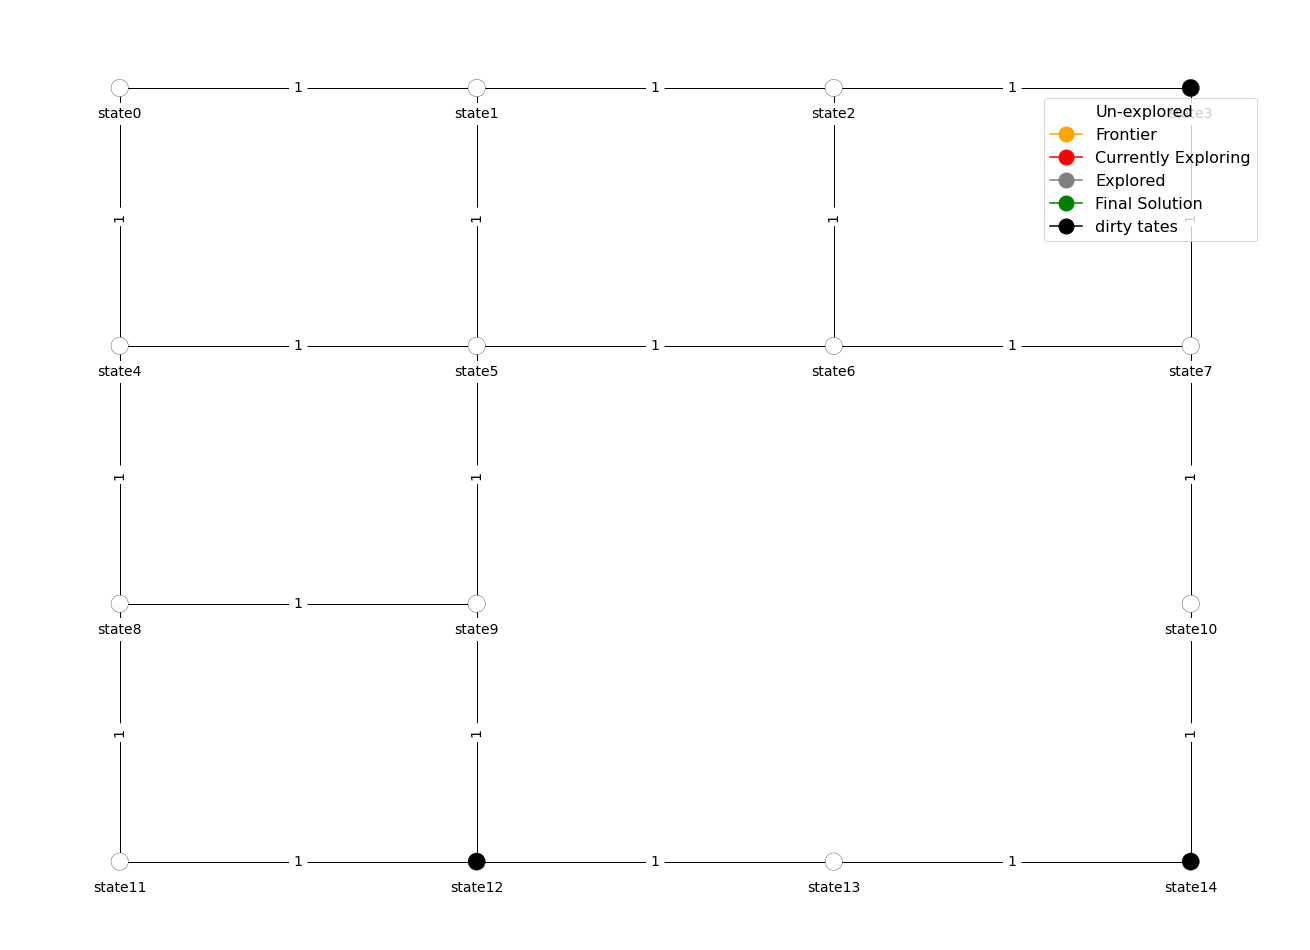

In [228]:
covid_graph = Graph(generate_connection_results())

covid_graph.locations = graph_locations()

# node colors, node positions and node label positions
for node in covid_graph.locations.keys():
    if node in dirty_states:
        node_colors[node] = 'black'
    else:
        node_colors[node] = 'white'

node_positions = covid_graph.locations
node_label_pos = { k:[v[0],v[1]-0.1]  for k,v in covid_graph.locations.items() }
edge_weights = {(k, k2) : v2 for k, v in covid_graph.graph_dict.items() for k2, v2 in v.items()}

covid_graph_data = {  'graph_dict' : covid_graph.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                         'edge_weights': edge_weights
                     }

show_map(covid_graph_data)

# ALL CELLS BELOW ARE FAILED ATTEMPTS AT GETTING THE VISUALISATION TO RUN. FOR 3.2 (CELL BELOW), AND 3.3

In [183]:
all_node_colors = []
covid_problem = GraphProblem('state0', final_states, covid_graph_data)
display_visual(covid_graph_data, user_input=False, 
               algorithm=astar_search_graph, 
               problem=covid_problem)

TypeError: 'Graph' object is not subscriptable

In [181]:
class CovidRobotProgram(SimpleProblemSolvingAgentProgram):                    
        def update_state(self, state, percept):
            return percept

        def formulate_goal(self, state):
            goal = final_states                                    
            return goal  

        def formulate_problem(self, state, goal):
            covid_problem = GraphProblem(state, goal, covid_graph)        ########## a generalisation of (1) to allow for any initial state
            return covid_problem  
    
        def search(self, problem): 
            display_visual(covid_graph_data, user_input=False, 
                           algorithm=astar_search_graph, 
                           problem=problem
                          )
a = CovidRobotProgram()
a('state0') 

interactive(children=(IntSlider(value=0, description='iteration', max=1), Output()), _dom_classes=('widget-int…

interactive(children=(ToggleButton(value=False, description='visualize'), Output()), _dom_classes=('widget-int…

# REFERENCE: CODE FROM LAB-5-SOLUTIONS

In [211]:
# import libraries
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines
import random
import numpy as np
import ipywidgets as widgets
from IPython.display import display
import functools
import heapq
import time
import search

# Pre-defined classes

class Graph:
    """A graph connects nodes (vertices) by edges (links). Each edge can also
    have a length associated with it. The constructor call is something like:
        g = Graph({'A': {'B': 1, 'C': 2})
    this makes a graph with 3 nodes, A, B, and C, with an edge of length 1 from
    A to B,  and an edge of length 2 from A to C. You can also do:
        g = Graph({'A': {'B': 1, 'C': 2}, directed=False)
    This makes an undirected graph, so inverse links are also added. The graph
    stays undirected; if you add more links with g.connect('B', 'C', 3), then
    inverse link is also added. You can use g.nodes() to get a list of nodes,
    g.get('A') to get a dict of links out of A, and g.get('A', 'B') to get the
    length of the link from A to B. 'Lengths' can actually be any object at
    all, and nodes can be any hashable object."""

    def __init__(self, graph_dict=None, directed=True):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        if not directed:
            self.make_undirected()

    def make_undirected(self):
        """Make a digraph into an undirected graph by adding symmetric edges."""
        for a in list(self.graph_dict.keys()):
            for (b, dist) in self.graph_dict[a].items():
                self.connect1(b, a, dist)

    def connect(self, A, B, distance=1):
        """Add a link from A and B of given distance, and also add the inverse
        link if the graph is undirected."""
        self.connect1(A, B, distance)
        if not self.directed:
            self.connect1(B, A, distance)

    def connect1(self, A, B, distance):
        """Add a link from A to B of given distance, in one direction only."""
        self.graph_dict.setdefault(A, {})[B] = distance

    def get(self, a, b=None):
        """Return a link distance or a dict of {node: distance} entries.
        .get(a,b) returns the distance or None;
        .get(a) returns a dict of {node: distance} entries, possibly {}."""
        links = self.graph_dict.setdefault(a, {})
        if b is None:
            return links
        else:
            return links.get(b)

    def nodes(self):
        """Return a list of nodes in the graph."""
        s1 = set([k for k in self.graph_dict.keys()])
        s2 = set([k2 for v in self.graph_dict.values() for k2, v2 in v.items()])
        nodes = s1.union(s2)
        return list(nodes)


def is_in(elt, seq):
    """Similar to (elt in seq), but compares with 'is', not '=='."""
    return any(x is elt for x in seq)


def distance(a, b):
    """The distance between two (x, y) points."""
    xA, yA = a
    xB, yB = b
    return np.hypot((xA - xB), (yA - yB))


class Problem:
    """The abstract class for a formal problem. You should subclass
    this and implement the methods actions and result, and possibly
    __init__, goal_test, and path_cost. Then you will create instances
    of your subclass and solve them with the various search functions."""

    def __init__(self, initial, goal=None):
        """The constructor specifies the initial state, and possibly a goal
        state, if there is a unique goal. Your subclass's constructor can add
        other arguments."""
        self.initial = initial
        self.goal = goal

    def actions(self, state):
        """Return the actions that can be executed in the given
        state. The result would typically be a list, but if there are
        many actions, consider yielding them one at a time in an
        iterator, rather than building them all at once."""
        raise NotImplementedError

    def result(self, state, action):
        """Return the state that results from executing the given
        action in the given state. The action must be one of
        self.actions(state)."""
        raise NotImplementedError

    def goal_test(self, state):
        """Return True if the state is a goal. The default method compares the
        state to self.goal or checks for state in self.goal if it is a
        list, as specified in the constructor. Override this method if
        checking against a single self.goal is not enough."""
        if isinstance(self.goal, list):
            return is_in(state, self.goal)
        else:
            return state == self.goal

    def path_cost(self, c, state1, action, state2):
        """Return the cost of a solution path that arrives at state2 from
        state1 via action, assuming cost c to get up to state1. If the problem
        is such that the path doesn't matter, this function will only look at
        state2. If the path does matter, it will consider c and maybe state1
        and action. The default method costs 1 for every step in the path."""
        return c + 1

    def value(self, state):
        """For optimization problems, each state has a value. Hill Climbing
        and related algorithms try to maximize this value."""
        raise NotImplementedError


class GraphProblem(Problem):
    """The problem of searching a graph from one node to another."""

    def __init__(self, initial, goal, graph):
        super().__init__(initial, goal)
        self.graph = graph

    def actions(self, A):
        """The actions at a graph node are just its neighbors."""
        return list(self.graph.get(A).keys())

    def result(self, state, action):
        """The result of going to a neighbor is just that neighbor."""
        return action

    def path_cost(self, cost_so_far, A, action, B):
        return cost_so_far + (self.graph.get(A, B) or np.inf)

    def find_min_edge(self):
        """Find minimum value of edges."""
        m = np.inf
        for d in self.graph.graph_dict.values():
            local_min = min(d.values())
            m = min(m, local_min)

        return m

    def h(self, node):
        """h function is straight-line distance from a node's state to goal."""
        locs = getattr(self.graph, 'locations', None)
        if locs:
            if type(node) is str:
                return int(distance(locs[node], locs[self.goal]))

            return int(distance(locs[node.state], locs[self.goal]))
        else:
            return np.inf

## Visualisation

def show_map(graph_data, node_colors=None):
    G = nx.Graph(graph_data['graph_dict'])
    node_colors = node_colors or graph_data['node_colors']
    node_positions = graph_data['node_positions']
    node_label_pos = graph_data['node_label_positions']
    edge_weights = graph_data['edge_weights']

    # set the size of the plot
    plt.figure(figsize=(18, 13))
    # draw the graph (both nodes and edges) with locations from romania_locations
    nx.draw(G, pos={k: node_positions[k] for k in G.nodes()},
            node_color=[node_colors[node] for node in G.nodes()], linewidths=0.3, edgecolors='k')

    # draw labels for nodes
    node_label_handles = nx.draw_networkx_labels(G, pos=node_label_pos, font_size=14)

    # add a white bounding box behind the node labels
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # add edge lables to the graph
    nx.draw_networkx_edge_labels(G, pos=node_positions, edge_labels=edge_weights, font_size=14)

    # add a legend
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="orange", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="red", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="gray", marker='o', markersize=15, markerfacecolor="gray")
    green_circle = lines.Line2D([], [], color="green", marker='o', markersize=15, markerfacecolor="green")
    black_circle = lines.Line2D([], [], color="black", marker='o', markersize=15, markerfacecolor="black")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle, green_circle, black_circle),
               ('Un-explored', 'Frontier', 'Currently Exploring', 'Explored', 'Final Solution', 'dirty tates'),
               numpoints=1, prop={'size': 16}, loc=(.8, .75))

    # show the plot. No need to use in notebooks. nx.draw will show the graph itself.
    plt.show()

# helper functions for visualisations

def final_path_colors(initial_node_colors, problem, solution):
    "Return a node_colors dict of the final path provided the problem and solution."

    # get initial node colors
    final_colors = dict(initial_node_colors)
    # color all the nodes in solution and starting node to green
    final_colors[problem.initial] = "green"
    for node in solution:
        final_colors[node] = "green"
    return final_colors


def display_visual(graph_data, user_input, algorithm=None, problem=None):
    initial_node_colors = graph_data['node_colors']
    print("1")

    def slider_callback(iteration):
        # don't show graph for the first time running the cell calling this function
        try:
            show_map(graph_data, node_colors=all_node_colors[iteration])
        except:
            pass

    def visualize_callback(visualize):
        if visualize is True:
            button.value = False
            # global all_node_colors
            while len(dirty_states) > 0:
                global all_node_colors
                # for dirty_state in dirty_states:
                iterations, all_node_colors, node = algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(all_node_colors[0], problem, solution))

                slider.max = len(all_node_colors) - 1

                for i in range(slider.max + 1):
                    slider.value = i
                    time.sleep(.5)
                problem.initial = problem.goal
                problem.goal = dirty_states[0]

    slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
    slider_visual = widgets.interactive(slider_callback, iteration=slider)
    display(slider_visual)

    button = widgets.ToggleButton(value=False)
    button_visual = widgets.interactive(visualize_callback, visualize=button)
    display(button_visual)

## Algorithms

def memoize(fn, slot=None, maxsize=32):
    """Memoize fn: make it remember the computed value for any argument list.
    If slot is specified, store result in that slot of first argument.
    If slot is false, use lru_cache for caching the values."""
    if slot:
        def memoized_fn(obj, *args):
            if hasattr(obj, slot):
                return getattr(obj, slot)
            else:
                val = fn(obj, *args)
                setattr(obj, slot, val)
                return val
    else:
        @functools.lru_cache(maxsize=maxsize)
        def memoized_fn(*args):
            return fn(*args)

    return memoized_fn

class Node:
    """A node in a search tree. Contains a pointer to the parent (the node
    that this is a successor of) and to the actual state for this node. Note
    that if a state is arrived at by two paths, then there are two nodes with
    the same state. Also includes the action that got us to this state, and
    the total path_cost (also known as g) to reach the node. Other functions
    may add an f and h value; see best_first_graph_search and astar_search for
    an explanation of how the f and h values are handled. You will not need to
    subclass this class."""

    def __init__(self, state, parent=None, action=None, path_cost=0):
        """Create a search tree Node, derived from a parent by an action."""
        self.state = state
        self.parent = parent
        self.action = action
        self.path_cost = path_cost
        self.depth = 0
        if parent:
            self.depth = parent.depth + 1

    def __repr__(self):
        return "<Node {}>".format(self.state)

    def __lt__(self, node):
        return self.state < node.state

    def expand(self, problem):
        """List the nodes reachable in one step from this node."""
        return [self.child_node(problem, action)
                for action in problem.actions(self.state)]

    def child_node(self, problem, action):
        """[Figure 3.10]"""
        next_state = problem.result(self.state, action)
        next_node = Node(next_state, self, action, problem.path_cost(self.path_cost, self.state, action, next_state))
        return next_node

    def solution(self):
        """Return the sequence of actions to go from the root to this node."""
        return [node.action for node in self.path()[1:]]

    def path(self):
        """Return a list of nodes forming the path from the root to this node."""
        node, path_back = self, []
        while node:
            path_back.append(node)
            node = node.parent
        return list(reversed(path_back))

    # We want for a queue of nodes in breadth_first_graph_search or
    # astar_search to have no duplicated states, so we treat nodes
    # with the same state as equal. [Problem: this may not be what you
    # want in other contexts.]

    def __eq__(self, other):
        return isinstance(other, Node) and self.state == other.state

    def __hash__(self):
        # We use the hash value of the state
        # stored in the node instead of the node
        # object itself to quickly search a node
        # with the same state in a Hash Table
        return hash(self.state)

# ______________________________________________________________________________
# Queues: Stack, FIFOQueue, PriorityQueue
# Stack and FIFOQueue are implemented as list and collection.deque
# PriorityQueue is implemented here


class PriorityQueue:
    """A Queue in which the minimum (or maximum) element (as determined by f and
    order) is returned first.
    If order is 'min', the item with minimum f(x) is
    returned first; if order is 'max', then it is the item with maximum f(x).
    Also supports dict-like lookup."""

    def __init__(self, order='min', f=lambda x: x):
        self.heap = []
        if order == 'min':
            self.f = f
        elif order == 'max':  # now item with max f(x)
            self.f = lambda x: -f(x)  # will be popped first
        else:
            raise ValueError("Order must be either 'min' or 'max'.")

    def append(self, item):
        """Insert item at its correct position."""
        heapq.heappush(self.heap, (self.f(item), item))

    def extend(self, items):
        """Insert each item in items at its correct position."""
        for item in items:
            self.append(item)

    def pop(self):
        """Pop and return the item (with min or max f(x) value)
        depending on the order."""
        if self.heap:
            return heapq.heappop(self.heap)[1]
        else:
            raise Exception('Trying to pop from empty PriorityQueue.')

    def __len__(self):
        """Return current capacity of PriorityQueue."""
        return len(self.heap)

    def __contains__(self, key):
        """Return True if the key is in PriorityQueue."""
        return any([item == key for _, item in self.heap])

    def __getitem__(self, key):
        """Returns the first value associated with key in PriorityQueue.
        Raises KeyError if key is not present."""
        for value, item in self.heap:
            if item == key:
                return value
        raise KeyError(str(key) + " is not in the priority queue")

    def __delitem__(self, key):
        """Delete the first occurrence of key."""
        try:
            del self.heap[[item == key for _, item in self.heap].index(True)]
        except ValueError:
            raise KeyError(str(key) + " is not in the priority queue")
        heapq.heapify(self.heap)


def best_first_graph_search_for_vis(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []

    for k in problem.graph.nodes():
        if k in dirty_states:
            node_colors[k] = 'black'
        else:
            node_colors[k] = 'white'
    # node_colors = {k : 'white' for k in problem.graph.nodes()}
    
    f = memoize(f, 'f')
    node = Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = PriorityQueue('min', f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        if node.state in dirty_states:
            dirty_states.remove(node.state)
            # print(len(dirty_states))
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < incumbent:
                    del frontier[child]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

# A* Search
def astar_search_graph(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memoize(h or problem.h, 'h')
    iterations, all_node_colors, node = best_first_graph_search_for_vis(problem, 
                                                                lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)



In [212]:
# Get paths 

# find the adjacent states of current states
def adjacent_states(cur_state, all_states_locs): # find possible states near the current state.
    adjacent_states_locs = []
    relative_states_location = [[-1,0],[1,0],[0,1],[0,-1]] # the possible locations according to the current location
    for i in relative_states_location:
        if all_states_locs.count([cur_state[0]+i[0],cur_state[1]+i[1]]) > 0:
            adjacent_states_locs.append([cur_state[0]+i[0],cur_state[1]+i[1]])
    return cur_state, adjacent_states_locs


# generate path information to draw graph
def generate_paths(all_states_locs):  
    # print(f"all states locs: {all_states_locs}")
    paths = {}
    for state_loc in all_states_locs:
        curr_state, adjacent_states_locs = adjacent_states(state_loc, all_states_locs)
        neighbor_states_dict = {}
        for adjacent_state_loc in adjacent_states_locs:
            neighbor_states_dict[f'state{all_states_locs.index(adjacent_state_loc)}'] = 1 # {'state1 : 0'}
        paths['state{}'.format(all_states_locs.index(state_loc))] = neighbor_states_dict # {'state1':  {'state2': 1}}
    return paths

# give all locations a name, i.e., 'state1' and store the names and locations in a dictionary
def graph_states(): # generate location of each state.
    locations_dict = {}
    for i in all_dict:
        locations_dict['state{}'.format(all_dict.index(i))] = (i[0]*scale,i[1]*scale)
    return locations_dict

In [220]:
map_size = w + 1 # we create an n x n graph, depending on the agents above environment
all_states_locs = [] # create a list which contains all the coordinates of each state.
dirty_states= [] 
for t in things_loc: #t is a coordinate for things (trolleys or chairs)
    num = map_size * t[1] + t[0]
    dirty_states.append("state{}".format(num)) #dirty/final states are those with trolleys or chairs on them
    
graph_person_location = [person_location[0], (map_size) - person_location[1]] #[x, y] ---> [x, n-y]

for i in range(map_size,0,-1):
    for j in range(0,map_size):
        all_states_locs.append([j,i])
all_states_locs.remove(graph_person_location) #we dont want this posititon to even exist in the graph as we cannot move through it


covid_graph = Graph(generate_paths(all_states_locs))
covid_graph.locations = generate_states(all_states_locs)


In [221]:
# define node_color
node_colors = {}
for node in covid_graph.locations.keys():
    if node in dirty_states:
        node_colors[node] = 'black'
    else:
        node_colors[node] = 'white'

# set the position of labels
node_positions = covid_graph.locations
node_label_pos = { k:[v[0],v[1]-12]  for k,v in covid_graph.locations.items() }

# set weight for each edge
edge_weights = {(k, k2) : v2 for k, v in covid_graph.graph_dict_items() for k2, v2 in v.items()}

covid_graph_data = {  'graph_dict' : covid_graph.graph_dict,
                        'node_colors': node_colors,
                        'node_positions': node_positions,
                        'node_label_positions': node_label_pos,
                        'edge_weights': edge_weights
                    }

show_map(covid_graph_data)

AttributeError: 'Graph' object has no attribute 'graph_dict_items'

In [ ]:
vacuum_n_n_map.graph_dict.items()

the_problem = GraphProblem('state0', dirty_states[0], vacuum_n_n_map)

display_visual(vacuum_n_n_graph_data, user_input=False,
                algorithm=astar_search_graph,
                problem=the_problem)